## Exam Scheduling with Graph Theory

In [1]:
#Running this cell displays a button to toggle hidden code
#From: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/

from IPython.display import HTML

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }
  
  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

This notebook takes data containing student ID numbers and what classes they take in order to create an optimal (minimum number of days) exam schedule with no conflicts. The conditions for this schedule are:

* There are two sessions for exams on each day - AM and PM.
* No student will write two exams on the same day.
* The exam space is limited to 150 students at any time.

### Exam Schedule

In [8]:
#Program works with data where column 2 contains student numbers, and column 3 contains class names (column 1 contains grade - unused)

#Info on the use of NetworkX:
#https://networkx.github.io/documentation/stable/tutorial.html
#https://networkx.github.io/documentation/latest/reference/algorithms/generated/networkx.algorithms.coloring.greedy_color.html#id6

#Grinpy used for finding chromatic number:
#https://pypi.org/project/grinpy/

#NOTES:
#Output conflict graph

import networkx as nx
import grinpy as gp
import pandas as pd
from IPython.display import display
import time
import matplotlib

start_time = time.time()
#main()
#print("--- %s seconds ---" % (time.time() - start_time))

final_solution_AM = []
final_solution_PM = []

#Opening excel file of data
file = 'Exam Scheduling Input Data.xlsx'

data = pd.read_excel(file)

#Getting the list of unique classes and students
classes = data.iloc[:, 2].tolist()
classes = set(classes)

students = data.iloc[:, 1].tolist()
students = set(students)

#Creating graph G
G = nx.Graph()

In [9]:


#Adding each unique class as a node in the graph
for item in classes:
    G.add_node(item)
    
#Create a dictionary that will be in the form: {student1 : [class1, class2], student2 : [class2, class4] ...}
student_dict = {}

#Create a dictionary that will be in the form: {class1: number of students in class1, ...}
class_dict = {}

    
for row in data.itertuples():
    
    #If this row is a student not yet added to the dict:
    if row[2] not in student_dict:
        
        #Add this student and the class for this row
        student_dict[row[2]] = [row[3]]
            
    #If the student already has a dictionary entry:
    else:
        
        #Add the class to the value list:
        student_dict[row[2]].append(row[3])
        
    #If this row is a class not yet added to the dict:
    if row[3] not in class_dict:
        
        #Add one to the number of students in this class:
        class_dict[row[3]] = 1
        
    #If the student already has a dictionary entry:
    else:
        
        #Add one to the number of students in this class:
        class_dict[row[3]] += 1
        
        
#Iterates through the dictionary of students, adding conflict edges between all the classes each student has:
for student in student_dict:
    
    #Iterates through all pairs of classes for the student:
    for x in range(0, len(student_dict[student])):
        for y in range (x+1, len(student_dict[student])):
            
            #Creates edge for conflict:
            G.add_edge(student_dict[student][x], student_dict[student][y])
            

#Finding chromatic number
chro_num = gp.chromatic_number(G)

#Finding number of nodes and eges in the conflict graph
node_count = G.number_of_nodes()
edge_count = G.number_of_edges()

#Finds all the cliques:
#cliques = nx.find_cliques(G)

run = True

#This whole loop applies the random-greedy coloring algorithm until all conditions are met
#I couldn't find a way to optimally color, so this is a hack-y solution in the mean time
while run == True:
    
    run = False
    
    #Tries a random-greedy algorithm for coloring the graph (couldn't find an optimal algorithm to use)
    color = nx.greedy_color(G, strategy = 'random_sequential')

    #Checks that generated coloring has chromatic number of colors, sets loop to run again if it doesn't
    for key in color:
        if color[key] >= chro_num:
            run = True
    
    #Checks that no single color has more than 300 students total taking an exam, sets loop to run again if failed
    if run == False:
        
        student_count = []
        
        for x in range(0, chro_num):
            student_count.append(0)
            
        for key in color:            
            student_count[color[key]] += class_dict[key]
            
        for x in student_count:
            if x >= 300:
                run = True
    
    #Tests different ways to organise the AM/PM slots so that no more than 150 students are writing at a time
    if run == False:
        
        temp_soln_AM = []
        temp_soln_PM = []
        for x in range(0, chro_num):
            temp_soln_AM.append([])
            temp_soln_PM.append([])
        
        student_count_AM = []
        student_count_PM = []
        
        for x in range(0, chro_num):
            student_count_AM.append(0)
            student_count_PM.append(0)
            
        for x in range(0, chro_num):
            for key in color:
                if color[key] == x:
                    
                    #If AM count will be below 150:
                    if student_count_AM[x] + class_dict[key] <= 150:
                        student_count_AM[x] += class_dict[key]
                        temp_soln_AM[x].append(key)
                    else:
                        student_count_PM[x] += class_dict[key]
                        temp_soln_PM[x].append(key)
                        
            if student_count_PM[x] > 150:
                run = True
                
        #Final check - if the solution is complete, set it to solution
        if run == False:
            final_solution_AM = temp_soln_AM
            final_solution_PM = temp_soln_PM
        
print("--- Run time: %s seconds ---" % (time.time() - start_time))

# #Prints final solution:
# print("EXAM SCHEDULE")
# print("______________")
# print()

# for day in range(0, chro_num):
    
#     print("    DAY " + str(day+1) + ": AM Session")
#     print()
    
#     for class_ in final_solution_AM[day]:
#         print(class_ + " with " + str(class_dict[class_]) + " students")
    
#     print()
#     print("Total students in session: " + str(student_count_AM[day]))
#     print()
#     print()
    
#     print("    DAY " + str(day+1) + ": PM Session")
#     print()
    
#     for class_ in final_solution_PM[day]:
#         print(class_ + " with " + str(class_dict[class_]) + " students")
    
#     print()
#     print("Total students in session: " + str(student_count_PM[day]))
#     print()
#     print()
    
    
#Puts schedule into a pandas dataframe:    
day_col = []
session_col = []
class_col = []
students_col = []

for day in range(0, chro_num):
    
    for class_ in final_solution_AM[day]:
        day_col.append("Day " + str(day+1) + ": " + str(student_count_AM[day]) + " / " + str(student_count_PM[day]) + " students")
        session_col.append("AM")
        class_col.append(class_)
        students_col.append(class_dict[class_])
    
    for class_ in final_solution_PM[day]:
        day_col.append("Day " + str(day+1) + ": " + str(student_count_AM[day]) + " / " + str(student_count_PM[day]) + " students")
        session_col.append("PM")
        class_col.append(class_)
        students_col.append(class_dict[class_])

d = {
    'Day': day_col,
    'Session': session_col,
    'Class': class_col,     
    'Students': students_col}

df = pd.DataFrame(d,columns=['Day','Session','Class','Students'])
df1=df.set_index(['Day', 'Session'])

df1

--- Run time: 3.7122654914855957 seconds ---


Class  Students
Day                       Session                                         
Day 1: 140 / 58 students  AM                          Calculus12        70
                          AM                            Spanish9        58
                          AM          FoundationsofMathematics11        12
                          PM                   Science10Enriched        22
                          PM            PreCalculus12Accelerated        18
                          PM          FoundationsofMathematics12        18
Day 2: 150 / 115 students AM                        Mathematics9        69
                          AM                 Chemistry11Enriched        56
                          AM                         Chemistry11        25
                          PM                         Chemistry12        52
                          PM                           Science10        63
Day 3: 134 / 124 students AM                           Physics11        77
                          AM                               Law12        57
                          PM                      SocialStudies9       124
Day 4: 144 / 109 students AM                       PreCalculus12        54
                          AM            PreCalculus11Accelerated        21
                          AM                       PreCalculus11        69
                          PM         FoundationsofMathPreCalc.10       109
Day 5: 131 / 0 students   AM          BiologyAnatomyPhysiology12        43
                          AM                             French9        35
                          AM                     French9Enriched        17
                          AM       BiologyLifeSciences11Enriched        12
                          AM               BiologyLifeSciences11        24
Day 6: 117 / 88 students  AM                            English9       117
                          PM                           History12        48
                          PM                     SocialStudies11        40
Day 7: 48 / 124 students  AM                           Physics12        34
                          AM                           Geology12        14
                          PM                            Science9       124

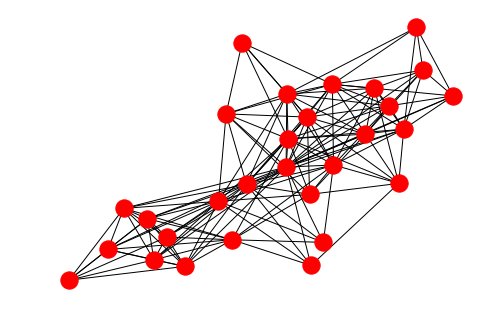

In [10]:
nx.draw(G)